In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score


In [37]:
file = "HealthSciences_Dataset.xlsx"
df_in = pd.read_excel(file,'data')
df=df_in #just so always have data_in when we change df

In [38]:
#to replace '?' in data with np.nan that will better allow for parsing
df.replace('?', np.nan, inplace=True)

In [39]:
df_in.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [40]:
print("Dataset Information: ")
print(df.info())

Dataset Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-

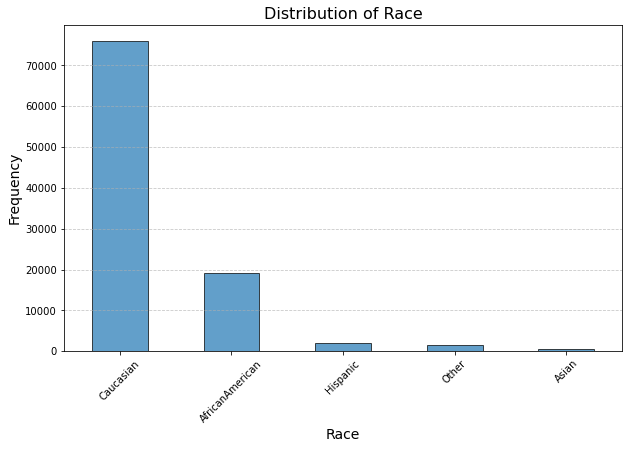

In [41]:
race_counts = df['race'].value_counts()
plt.figure(figsize=(10, 6))  # Set the figure size
race_counts.plot(kind='bar', color='tab:blue', edgecolor='black', alpha=0.7)  # Create a bar plot
plt.title('Distribution of Race', fontsize=16)  # Set the title and its font size
plt.xlabel('Race', fontsize=14)  # Set the x-label and its font size
plt.ylabel('Frequency', fontsize=14)  # Set the y-label and its font size
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid on the y-axis for better readability
plt.show()  # Display the plot


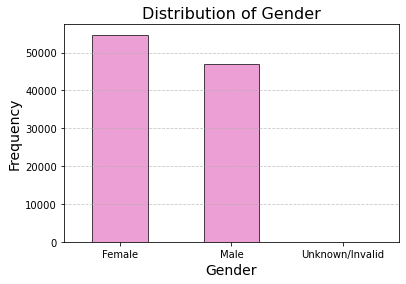

In [42]:
gender_counts = df['gender'].value_counts()
gender_counts.plot(kind='bar', color='tab:pink', edgecolor='black', alpha=0.7)  # Create a bar plot
plt.title('Distribution of Gender', fontsize=16)  # Set the title and its font size
plt.xlabel('Gender', fontsize=14)  # Set the x-label and its font size
plt.ylabel('Frequency', fontsize=14)  # Set the y-label and its font size
plt.xticks(rotation=0)  # Rotate the x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid on the y-axis for better readability
plt.show()  # Display the plot

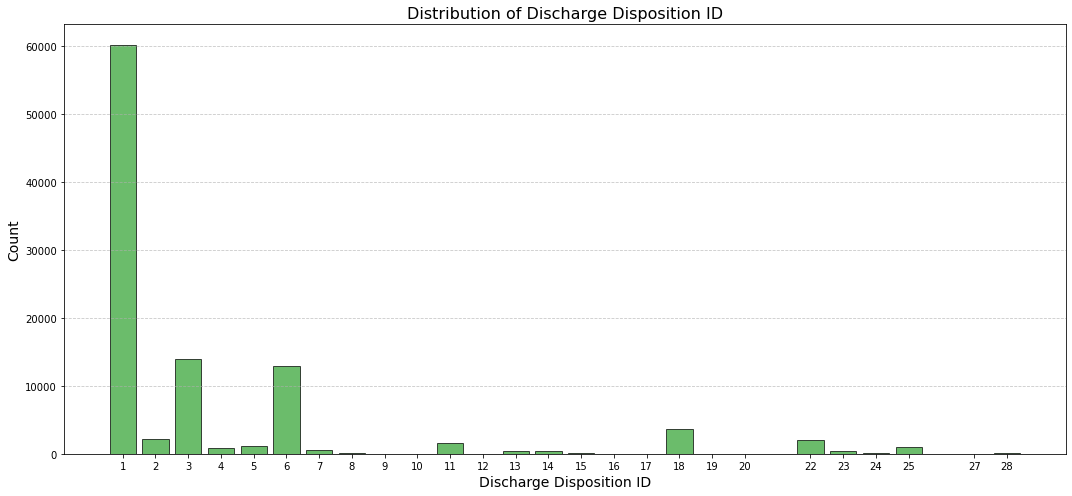

In [43]:
value_counts = df['discharge_disposition_id'].value_counts().sort_index()

# Plot bar graph
plt.figure(figsize=(15, 7))
plt.bar(value_counts.index, value_counts.values, color='tab:green',edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Discharge Disposition ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Discharge Disposition ID', fontsize=16)

# Adding grid and showing the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(value_counts.index)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()

In [44]:
# All the categories in discharge_disposition_id that we consider to be serious care
patients_serious_care = [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 19, 20, 21, 22, 23, 24]


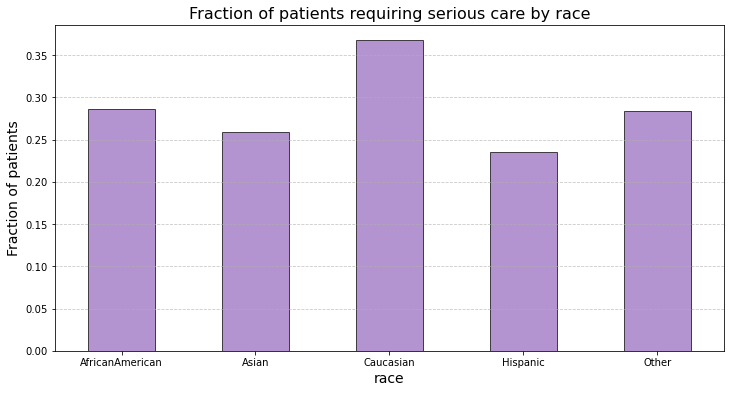

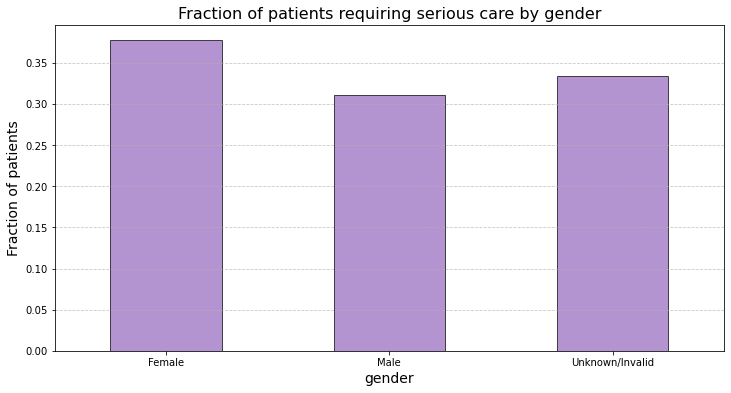

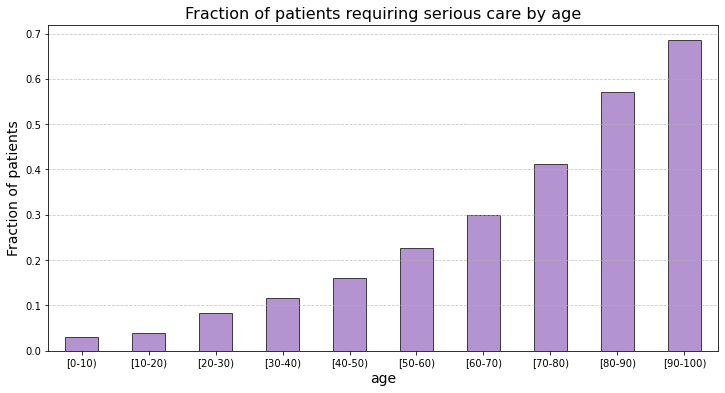

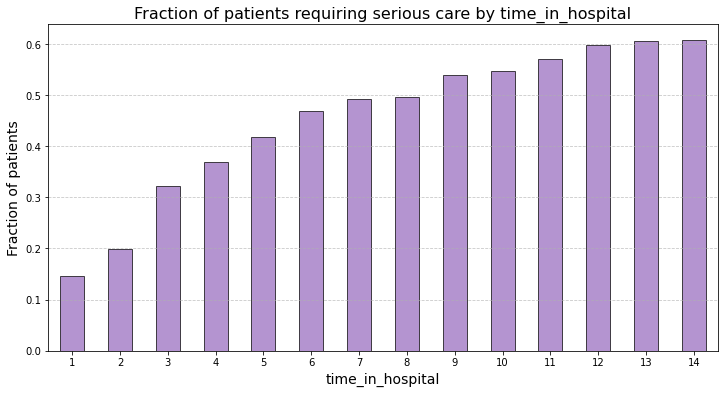

In [45]:
# Function to plot fraction of patients requiring serious care by different parameter
def plot_fraction(df, column_name, serious_care_ids):
    serious_care_df = df[df['discharge_disposition_id'].isin(serious_care_ids)]
    serious_care_count = serious_care_df[column_name].value_counts()
    total_count = df[column_name].value_counts()
    fraction_serious_care = (serious_care_count / total_count).fillna(0).sort_index()
    plt.figure(figsize=(12, 6))
    fraction_serious_care.plot(kind='bar', color='tab:purple',edgecolor='black', alpha=0.7)
    
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel(f'Fraction of patients', fontsize=14)
    plt.title(f'Fraction of patients requiring serious care by {column_name}', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45 if column_name == 'weight' else 0)  # Rotate only for weight as it may have multiple categories    
    plt.show()
plot_fraction(df, 'race', patients_serious_care)
plot_fraction(df, 'gender', patients_serious_care)
plot_fraction(df, 'age', patients_serious_care)
plot_fraction(df, 'time_in_hospital', patients_serious_care)
#Almost all of the values of weight are missing so it's best to not plot it
# plot_fraction(df, 'weight', patients_serious_care) 

In [46]:
# Print the number of missing data in each column
missing_data = df.isnull().sum()
print("Number of missing data in each column:")
for col, num_missing in missing_data.items():
    if num_missing > 0:
        print(f"{col}: {num_missing}")

Number of missing data in each column:
race: 2273
weight: 98569
payer_code: 40256
medical_specialty: 49949
diag_1: 21
diag_2: 358
diag_3: 1423


In [47]:
#It's best to drop weight, payer_code and medical_specialty columns
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

In [48]:
print(len(df))
df_cleaned = df.dropna() # drop rows in df where any cell is null
print(len(df_cleaned))
#Looks like we only lose about 3000 rows when we remove the rows so we will just keep this instead of extrapolating

101766
98053


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


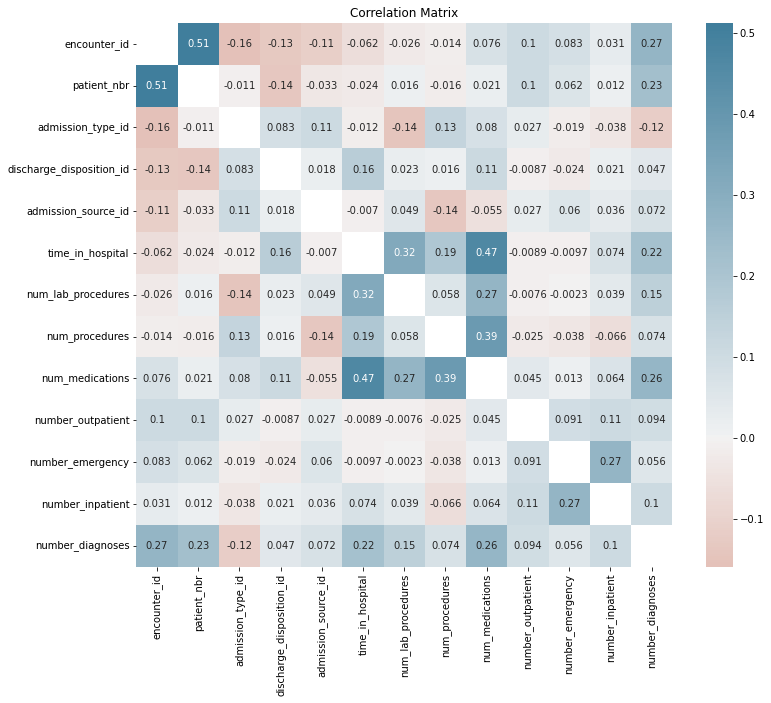

In [49]:
corr = df.corr()
plt.figure(figsize=(12, 10))
mask = np.zeros_like(corr, dtype=bool)
np.fill_diagonal(mask, True) #fill diagnonal values as True so we can skip them
cmap = sns.diverging_palette(20, 230, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [50]:
#Not a big correlation amoungnst variables

In [51]:
# corr_2 = serious_care_df.corr()
# plt.figure(figsize=(12, 10))
# mask = np.zeros_like(corr_2, dtype=bool)
# np.fill_diagonal(mask, True) #fill diagnonal values as True so we can skip them
# cmap = sns.diverging_palette(20, 230, as_cmap=True)
# sns.heatmap(corr_2, mask=mask, cmap=cmap, center=0, annot=True)
# plt.title('Correlation Matrix')
# plt.show()
# #Nope

In [52]:
df['serious_care'] = df['discharge_disposition_id'].isin(patients_serious_care).astype(int)
df.head()

#serious_care = 1 if they will need serious care in future or zero otherwise

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,serious_care
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


In [53]:
#Debugged using chatgpt


# Separate target from predictors
y = df['serious_care']
X = df.drop(['serious_care'], axis=1)

# Identify categorical columns
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Convert all categorical columns to string type
for col in categorical_cols:
    X[col] = X[col].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = categorical_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])



In [54]:
# LogisticRegression
model_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
model_lr.fit(X_train, y_train)
from sklearn.metrics import accuracy_score

# Predict the labels of the test set: y_pred
y_pred = model_lr.predict(X_test)

# Compute and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))
# Maybe Logistic regression is not ideal

Accuracy: 0.6468507418689201


In [55]:
#Random Forest
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy))

# Compute and print the recall
recall = recall_score(y_test, y_pred, pos_label=1) # Assuming 1 is the positive class label
print("Recall: {}".format(recall))
#Recall is important as we want to avoid false negative

Accuracy: 0.6468507418689201
Recall: 0.976349471341124


In [56]:
# Save model to file
filename = 'trained_model.joblib'
joblib.dump(model, filename)

['trained_model.joblib']

In [57]:
# Load the model from the file so we don't have to train again everytime
filename = 'trained_model.joblib'
model = joblib.load(filename)


In [ ]:
import shap
# Documnetation of the library here: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
# # Transform the test set using preprocessor
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

X_test_transformed = X_test_transformed.astype(float)
X_test_transformed = X_test_transformed.toarray() if hasattr(X_test_transformed, 'toarray') else X_test_transformed

# Extract RandomForestClassifier from the pipeline
rf_model = model.named_steps['classifier']

# # # Initialize the TreeExplainer
explainer = shap.TreeExplainer(rf_model, feature_perturbation='interventional')

subset_size = 10  #test on a small data, should make it bigger later
subset = X_test_transformed[:subset_size]
shap_values = explainer.shap_values(subset)
shap.summary_plot(shap_values, subset)